## Background

In this notebook I'll work through the following prompt given in the "Further Research" section of Chapter 13 (Convolutional Neural Networks):

> Try moving the activation function after the batch normalization layer in `conv`. Does it make a difference? See what you can find out about what order is recommended and why.

In [1]:
from fastai.vision.all import *
from fastai.callback.hook import *
matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

## Activation Function After Batch Normalization

I'll first train a model with the same architecture as the textbook---the activation function (in this case `nn.ReLU`) is placed after `nn.BatchNorm2d` in `nn.Sequential`.

In [3]:
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [5]:
conv(1,8) # activation function is after batch normalization

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

I'll re-use the `simple_cnn` architecture as well as the `get_dls` and `fit` helper functions defined in the textbook:

In [3]:
def simple_cnn():
  return sequential(
      conv(1, 8, ks=5),         # 14x14
      conv(8, 16),              # 7x7
      conv(16, 32),             # 4x4
      conv(32, 64),             # 2x2
      conv(64, 10, act=False),  # 1x1
      Flatten()
  )

In [4]:
# create a function to change dls params
def get_dls(bs=64):
  return DataBlock(
      blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items=get_image_files,
      splitter=GrandparentSplitter('training', 'testing'),
      get_y=parent_label,
      batch_tfms=Normalize()
  ).dataloaders(path, bs=bs)

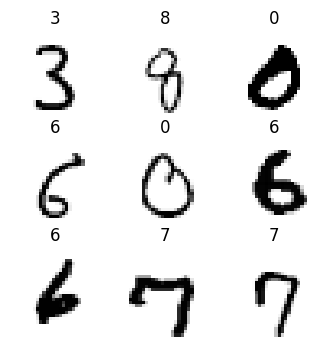

In [5]:
dls = get_dls(512)
dls.show_batch(max_n=9, figsize=(4,4))

In [10]:
def fit(epochs=1, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs, lr)
  return learn

In [11]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.135710,0.056765,0.986600,01:10


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


I'll take a look at the activation distribution across batches in a couple of ways:

- `color_dim` which will display an image where each column of pixels is a histogram of one batch of activations where lighter colors are close to zero and darker colors are non-zero.
- `plot_layer_stats` which displays the mean, standard deviation and %-near-zero activations across batches during training.

The output of `color_dim` looks as expected---a smooth transition from zero to non-zero activations.

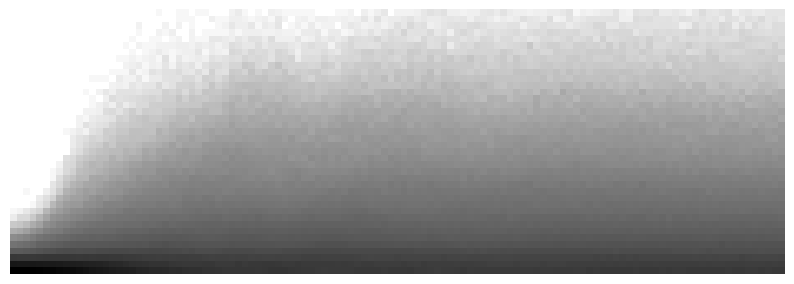

In [12]:
learn.activation_stats.color_dim(-4)

The % near zero chart looks better than the counterexamples in the text but it still looks pretty high (~65% of the activations are near zero after batch #25).

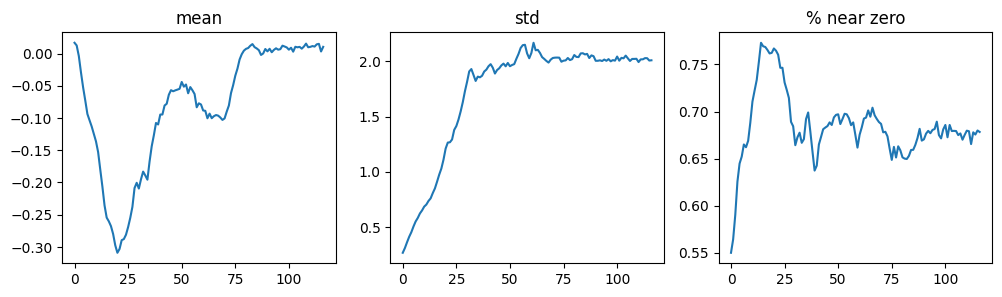

In [13]:
learn.activation_stats.plot_layer_stats(-2)

## Activation Function Before Batch Normalization

Next, I'll reverse the order of `nn.ReLU` and `nn.BatchNorm2d`, placing the activation function **before** the batch normalization:

In [14]:
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  if act: layers.append(nn.ReLU()) # activation function before batch norm
  layers.append(nn.BatchNorm2d(nf))
  return nn.Sequential(*layers)

In [15]:
conv(1,8)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
simple_cnn()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

The accuracy is slightly higher than when the activation function was placed after the batch norm (0.986600):

In [17]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.130553,0.055105,0.987000,01:09


The activations look pretty good and it seems like there are greater non-zero activations to start with in this model, which is an improvement.

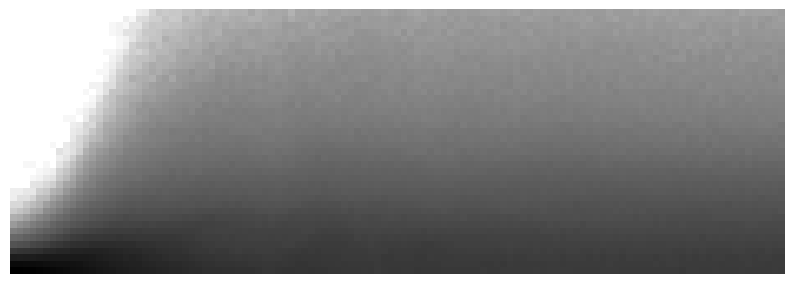

In [18]:
learn.activation_stats.color_dim(-4)

The standard deviation of the activations are smoother than before. However, there are more near-zero activations (and % near zero increases during training) which is a downside to this architecture.

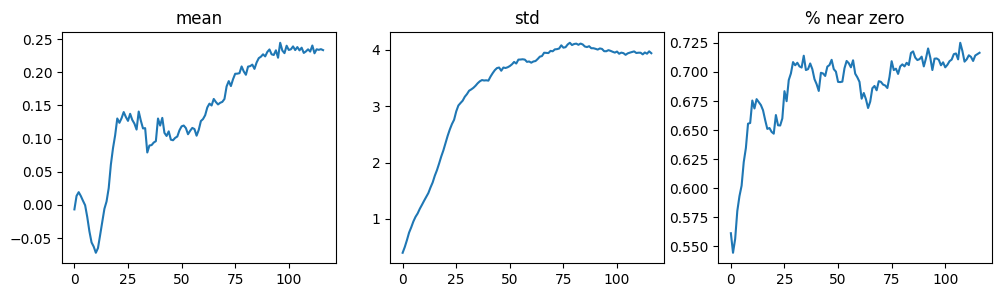

In [19]:
learn.activation_stats.plot_layer_stats(-2)

## Running More Experiments

It's tough to arrive at a conclusion with just one model for each architecture trained for just 1 epoch. To get a better sense of how performance is affected by the position of the activation function, I'll train 10 models for 5 epochs for each architecture, storing the activation stats along the way.

To store the activation stats, I'll grab the `layer_stats` for the penultimate layer (idx = `-2`) for each training run.

I'll store the `layer_stats` object in an `L` object so I can use the `itemgot` method to get the mean, standard deviation and %-near-zero values across trainings.

I'll also store each training run's `hist`ograms to view the output of `color_dim` manually (using idx = `-4` as done in the textbook):

In [41]:
h = learn.activation_stats.hist(-4)

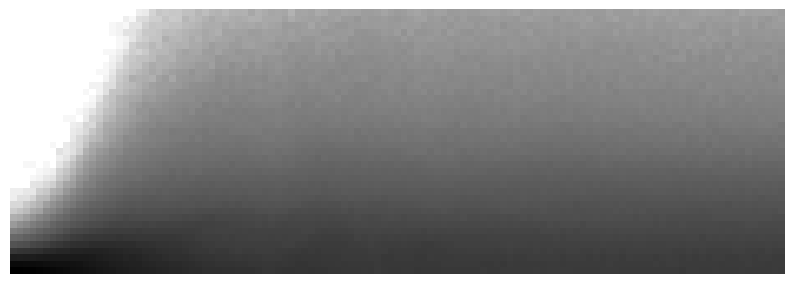

In [46]:
ax = subplots(figsize=(10,5))[1][0]
ax.imshow(h, origin='lower');
ax.axis('off');

### Activation Function After Batch Normalization

I'll update `fit` so that it doesn't display the progress bar and logging during training (so that I don't get a screen full of logs):

In [6]:
def fit(epochs=5, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  with learn.no_logging(), learn.no_bar(): learn.fit_one_cycle(epochs, lr)
  return learn

I'll train 10 models, each for 5 epochs, and save the `layer_stats` and `hist` for each model. I'll also make sure to define `conv` such that the activation function is _after_ the batch normalization.

These training runs should take about 50 minutes in total.

In [7]:
layer_stats_after = L()
hist_after = L()

def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU()) # activation function after batch norm
  return nn.Sequential(*layers)

for _ in range(10):
  learn = fit()
  layer_stats_after.append(learn.activation_stats.layer_stats(-2))
  hist_after.append(learn.activation_stats.hist(-4))

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


### Activation Function Before Batch Normalization

I'll run a similar set of trainings for the architecture where the activation function is placed **before** batch normalization.

In [11]:
layer_stats_before = L()
hist_before = L()

def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  if act: layers.append(nn.ReLU()) # activation function before batch norm
  layers.append(nn.BatchNorm2d(nf))
  return nn.Sequential(*layers)

for _ in range(10):
  learn = fit()
  layer_stats_before.append(learn.activation_stats.layer_stats(-2))
  hist_before.append(learn.activation_stats.hist(-4))

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


### Analysis of Training Results

I'll start by plotting the mean, standard deviation and %-near-zero activations for both architectures (activation function before/after batch norm).

I'll create this helper function to plot the spread of mean, standard deviation and %-near-zero activations:

In [51]:
def plot_stats_spread(layer_stats, titles, super_title):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(super_title, fontsize=16)

  for i, title in enumerate(titles):
    y = layer_stats.itemgot(i)
    x = range(len(y[0]))

    y_min = np.minimum.reduce(y)
    y_max = np.maximum.reduce(y)

    axs[i].fill_between(x, y_min, y_max, alpha=0.5)
    axs[i].set_title(f"Spread of {title} Activations Across 10 Trainings")
    axs[i].set_xlabel("Batch")
    axs[i].set_ylabel(f"{title}")

  plt.tight_layout()
  plt.show()

In [52]:
titles = ['Mean', 'Std', '%-near-zero']

In the following six charts, I plot the spread or range of activation stats over 5 epochs across the 10 trainings. I chose to plot the spread (instead of 10 line plots) so that you can more easily see the range of values for each statistic.

When the activation function is placed **after** the batch norm, the standard deviations and the %-age of activations near zero are lower than when the activation is placed **before** the batch norm. This shows the benefit of placing the activation after the batch norm.



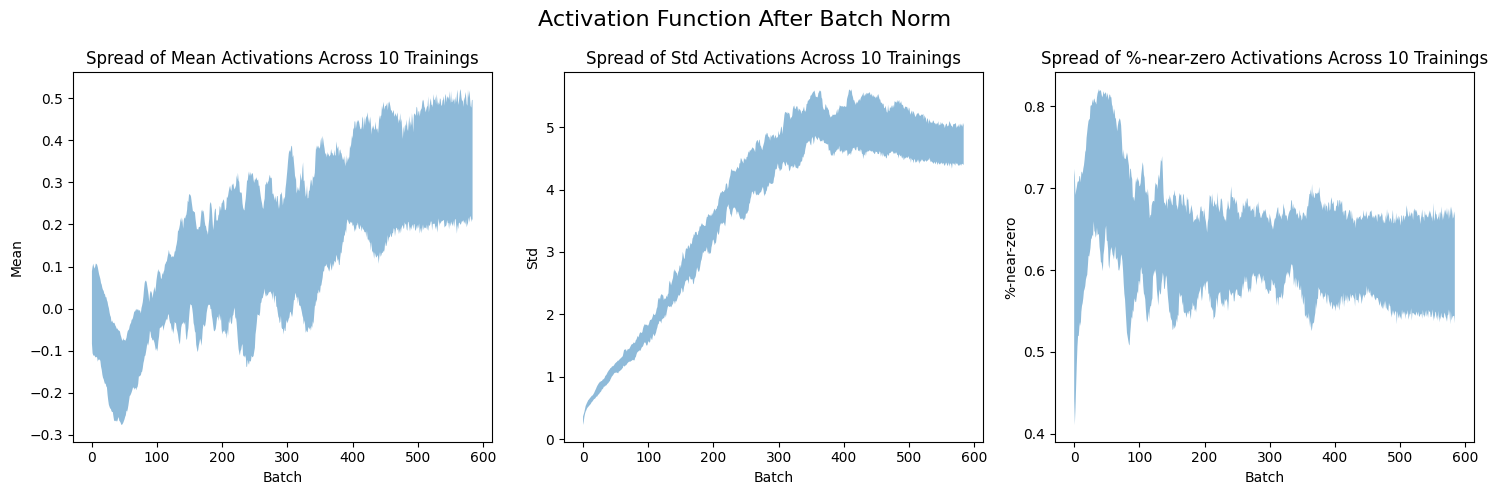

In [53]:
plot_stats_spread(layer_stats_after, titles, "Activation Function After Batch Norm")

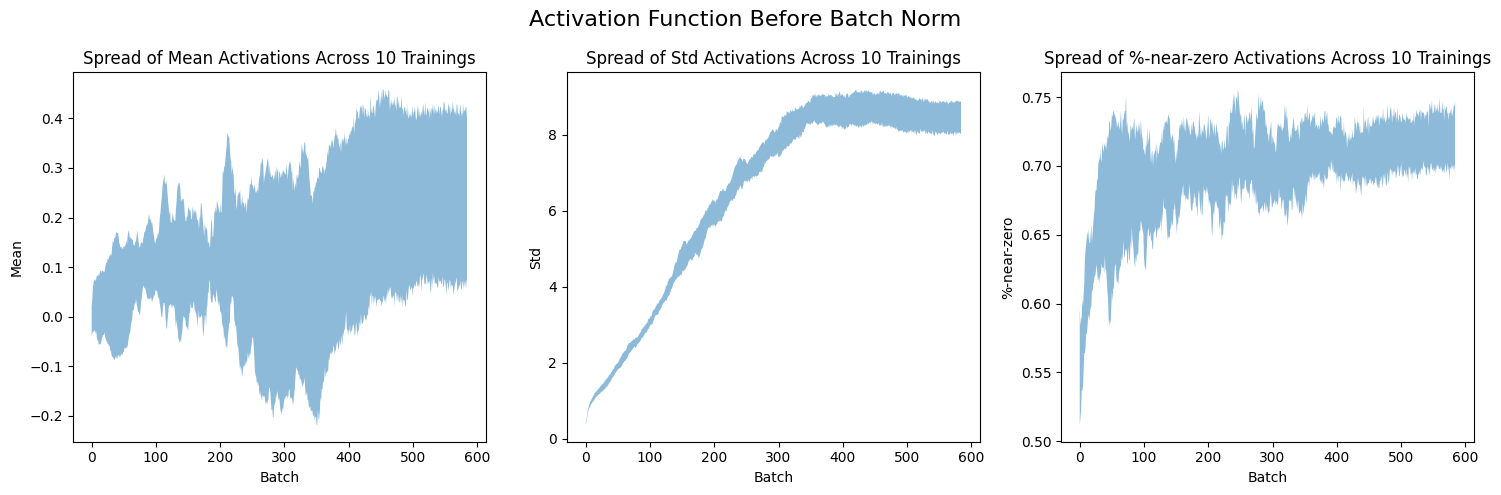

In [54]:
plot_stats_spread(layer_stats_before, titles, "Activation Function Before Batch Norm")

I'll create a helper function to plot the mean and median values for each statistic:

In [65]:
def plot_stats_avg(layer_stats, titles, super_title):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(super_title, fontsize=16)

  for i, title in enumerate(titles):
    y = layer_stats.itemgot(i)
    x = range(len(y[0]))

    y_mean = np.mean(np.stack(y), axis=0)
    y_median = np.median(np.stack(y), axis=0)

    axs[i].plot(x, y_mean, color='red', alpha=0.5, linewidth=1)
    axs[i].plot(x, y_median, color='blue', alpha=0.5, linewidth=1)
    axs[i].set_title(f"Average {title} Activations Across 10 Trainings")
    axs[i].set_xlabel("Batch")
    axs[i].set_ylabel(f"{title}")

  plt.tight_layout()
  plt.show()

The mean (red) and median (blue) values across the 10 training runs for each architecture show the same trends: lower standard deviation and lower %-near-zero activations when the activation function is placed after batch norm. Additionally, the average mean activations for the first 100 or so batches are less than 0 when the activation function is placed after the batch norm.


Overall, these plots reiterate the benefit of placing the activation function after the batch norm.

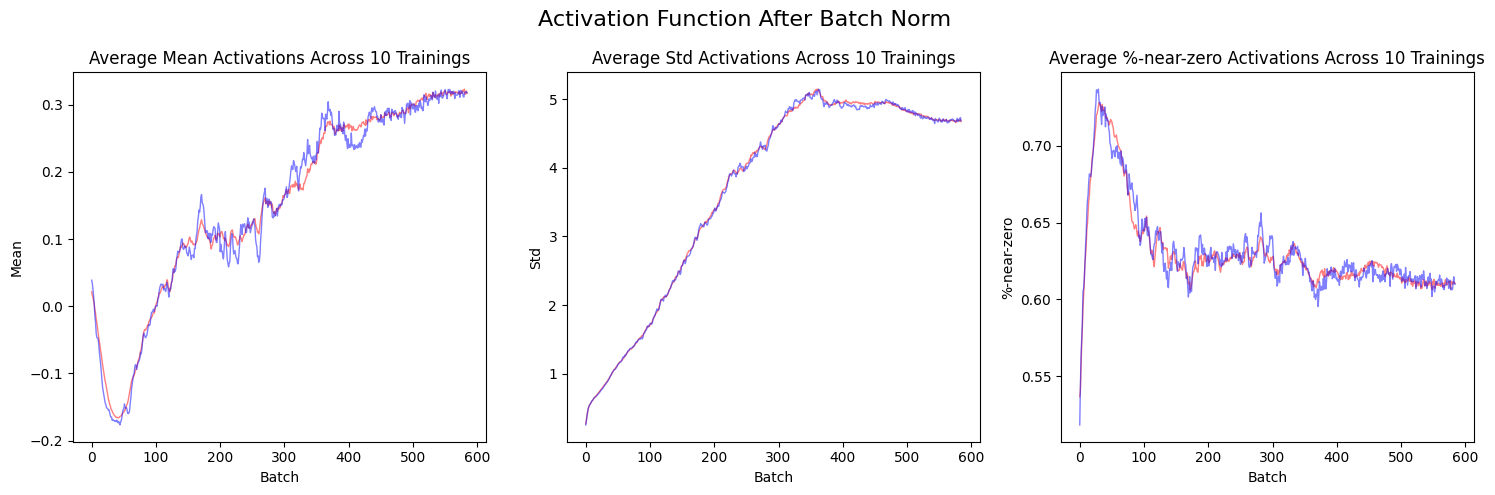

In [66]:
plot_stats_avg(layer_stats_after, titles, "Activation Function After Batch Norm")

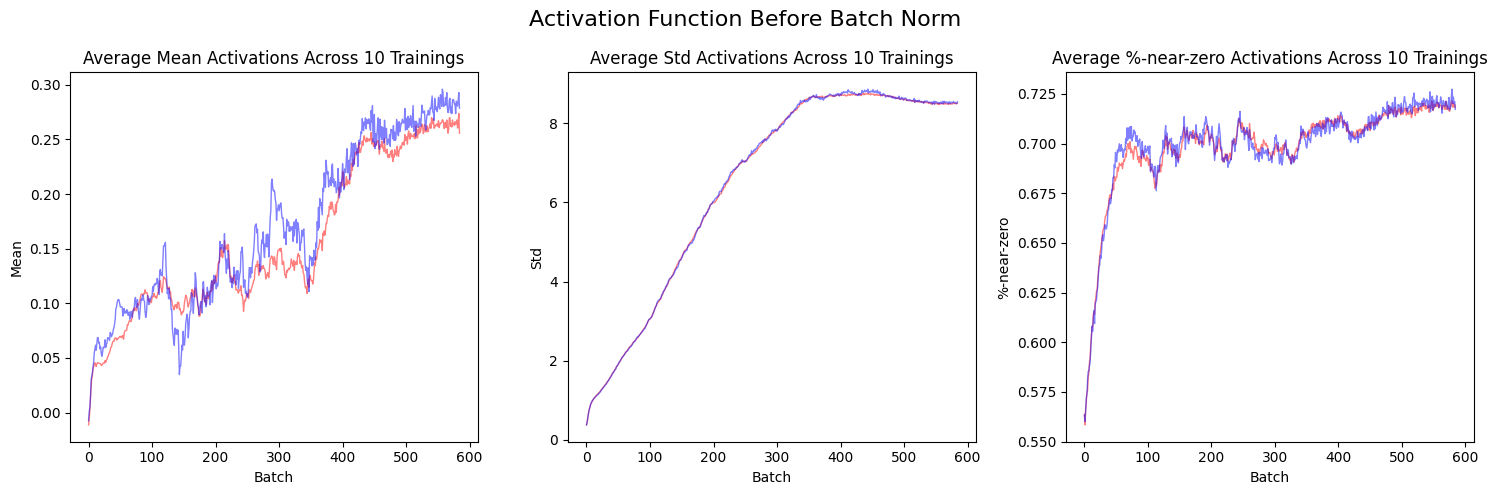

In [67]:
plot_stats_avg(layer_stats_before, titles, "Activation Function Before Batch Norm")

Next, I'll look at histograms of mean and median activation values for both architectures:

In [83]:
def plot_hist_avg(hist, super_title):
  fig, axs = plt.subplots(2, 1, figsize=(20, 5))
  fig.suptitle(super_title, fontsize=16)
  h_mean = torch.stack(list(hist)).mean(0)
  h_median = torch.stack(list(hist)).median(0)[0]

  axs[0].imshow(h_mean, origin='lower');
  axs[0].set_title(f"Mean Activations Across 10 Trainings")
  axs[0].axis('off');

  axs[1].imshow(h_median, origin='lower');
  axs[1].set_title(f"Median Activations Across 10 Trainings")
  axs[1].axis('off');

It's tough to visually distinguish between the different shades of gray but the clear difference is that the non-zero activations when the activation function is placed after batch norm increase much slower than when it's placed before.

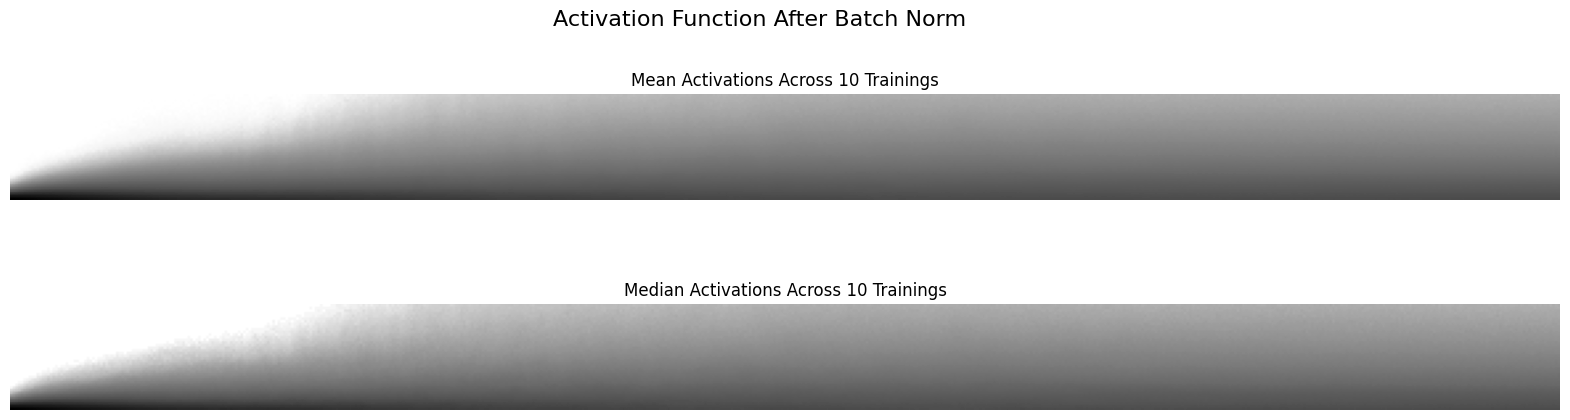

In [84]:
plot_hist_avg(hist_after, "Activation Function After Batch Norm")

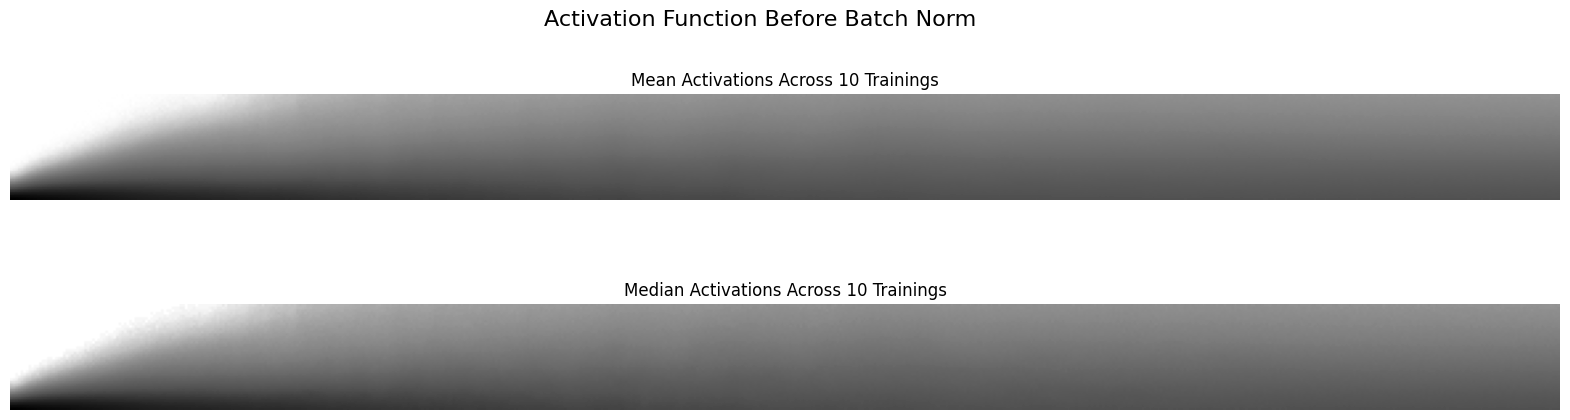

In [85]:
plot_hist_avg(hist_before, "Activation Function Before Batch Norm")

## References to Batch Norm Placement

My quick experiments show that placing the activation function after the batch normalization is preferred because it decreases the %-age of activations that are near zero, and decreases the standard deviation of the activations, both which are signs of "stable" training.

However, these are just quick, rough experiments. What do the experts say? I googled around and found the following:

[This fastai forums thread](https://forums.fast.ai/t/where-should-i-place-the-batch-normalization-layer-s/56825/6) which led me to more resources.

In the original [Batch Normalization paper](https://arxiv.org/pdf/1502.03167) the authors state (emphasis mine):

> We add the BN transform immediately **before** the nonlinearity, by normalizing $x = Wu+ b$

A quick note that BN before nonlinearity = nonlinearity after BN (which is the terminology I have been using: "activation function before BN" and "activation function after BN").

They compare placing BN before and after the nonlinearity---my experiments matches their explanation, that the activations are sparser (i.e. there are more near-zero activations) when BN is placed after the nonlinearity (emphasis mine):

> The goal of Batch Normalization
is to achieve a stable distribution of activation values
throughout training, and in our experiments we apply it
**before** the nonlinearity since that is where matching the
first and second moments is more likely to result in a
stable distribution. On the contrary, (Gulcehre & Bengio,
2013) apply the standardization layer to the output of the
nonlinearity, **which results in sparser activations**. In our
large-scale image classification experiments, _we have not
observed the nonlinearity inputs to be sparse, neither with
nor without Batch Normalization_.

I didn't explore it here, but they also compare placing BN to the layer inputs before the weights are applied (which can be seen as another way of placing it _after_ the nonlinearity; emphasis mine):

> We could have also normalized the layer inputs $u$, but since $u$ is likely
the _output of another nonlinearity_, the shape of its distribution is likely to change during training, and constraining its first and second moments would not eliminate the covariate shift. In contrast, $Wu + b$ is more likely to have
a symmetric, non-sparse distribution, that is “more Gaussian” (Hyvarinen & Oja, 2000); normalizing it is likely to produce activations with a stable distribution.

In a [2016 Keras GitHub comment](https://github.com/keras-team/keras/issues/1802#issuecomment-187966878) Francois Chollet said (emphasis mine):

> I haven't gone back to check what they are suggesting in their original paper, but I can guarantee that recent code written by Christian **applies relu before BN**. It is still occasionally a topic of debate, though.

## Final Thoughts

This portion of the Chapter got me excited because I felt I was finally peaking under the hood to see the dynamics of a neural net training run. The `activation_stats` callback is a simple but powerful tool to understand how different architectural changes are affecting training dynamics. I look forward to digging deeper under the hood in part 2 of the course!

I hope you enjoyed this blog post. Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).